In [21]:
import sys
import math
import uproot
import operator
import numpy as np
import ROOT  as r
import matplotlib.pyplot as plt

In [2]:
try   : from scipy.optimize import leastsq
except: leastsq = None


mT = 172.5   # GeV : top quark mass
mW = 80.385  # GeV : W boson mass
mN = 0       # GeV : neutrino mass


def UnitCircle():
    '''Unit circle in extended representation'''
    return np.diag([1, 1, -1])


def cofactor(A, i, j):
    '''Cofactor[i,j] of 3x3 matrix A'''
    a = A[not i:2 if i==2 else None:2 if i==1 else 1,
          not j:2 if j==2 else None:2 if j==1 else 1]
    return (-1)**(i+j) * (a[0,0]*a[1,1] - a[1,0]*a[0,1])


def R(axis, angle):
    '''Rotation matrix about x(0),y(1), or z(2) axis'''
    c, s = math.cos(angle), math.sin(angle)
    R = c * np.eye(3)
    for i in [-1, 0, 1]:
        R[(axis-i) % 3, (axis+i) % 3] = i*s + (1 - i*i)
    return R


def Derivative():
    '''Matrix to differentiate [cos(t),sin(t),1]'''
    return R(2, math.pi / 2).dot(np.diag([1, 1, 0]))


def multisqrt(y):
    '''Valid real solutions to y=x*x'''
    return ([] if y < 0 else
            [0] if y == 0 else
            (lambda r: [-r, r])(math.sqrt(y)))


def factor_degenerate(G, zero=0):
    '''Linear factors of degenerate quadratic polynomial'''
    if G[0,0] == 0 == G[1,1]:
        return [[G[0,1], 0, G[1,2]],
                [0, G[0,1], G[0,2] - G[1,2]]]

    swapXY = abs(G[0,0]) > abs(G[1,1])
    Q = G[(1,0,2),][:,(1,0,2)] if swapXY else G
    Q /= Q[1,1]
    q22 = cofactor(Q, 2, 2)

    if -q22 <= zero:
        lines = [[Q[0,1], Q[1,1], Q[1,2]+s]
                 for s in multisqrt(-cofactor(Q, 0, 0))]
    else:
        x0, y0 = [cofactor(Q, i, 2) / q22 for i in [0, 1]]
        lines = [[m, Q[1,1], -Q[1,1]*y0 - m*x0]
                 for m in [Q[0,1] + s
                           for s in multisqrt(-q22)]]

    return [[L[swapXY],L[not swapXY],L[2]] for L in lines]


def intersections_ellipse_line(ellipse, line, zero=1e-12):
    '''Points of intersection between ellipse and line'''
    _,V = np.linalg.eig(np.cross(line,ellipse).T)
    sols = sorted([(v.real / v[2].real,
                    np.dot(line,v.real)**2 +
                    np.dot(v.real,ellipse).dot(v.real)**2)
                    for v in V.T],
                    key=lambda s: s[1])[:2]
    return [s for s, k in sols if k < zero]


def intersections_ellipses(A, B, returnLines=False):
    '''Points of intersection between two ellipses'''
    LA = np.linalg
    if abs(LA.det(B)) > abs(LA.det(A)): A,B = B,A
    e = next(e.real for e in LA.eigvals(LA.inv(A).dot(B))
             if not e.imag)
    lines = factor_degenerate(B - e*A)
    points = sum([intersections_ellipse_line(A,L)
                  for L in lines],[])
    return (points,lines) if returnLines else points


class nuSolutionSet(object):
    '''Definitions for nu analytic solution, t->b,mu,nu'''

    def __init__(self, b, mu,  # Lorentz Vectors
                 mW2=mW**2, mT2=mT**2, mN2=mN**2):
        c = r.Math.VectorUtil.CosTheta(b,mu)
        s = math.sqrt(1-c**2)

        x0p = - (mT2 - mW2 - b.M2()) / (2*b.E())
        x0 = - (mW2 - mu.M2() - mN2) / (2*mu.E())

        Bb, Bm = b.Beta(), mu.Beta()

        Sx = (x0 * Bm - mu.P()*(1-Bm**2)) / Bm**2
        Sy = (x0p / Bb - c * Sx) / s

        w = (Bm / Bb - c) / s
        w_ = (-Bm / Bb - c) / s

        Om2 = w**2 + 1 - Bm**2
        eps2 = (mW2 - mN2) * (1 - Bm**2)
        x1 = Sx - (Sx+w*Sy) / Om2
        y1 = Sy - (Sx+w*Sy) * w / Om2
        Z2 = x1**2 * Om2 - (Sy-w*Sx)**2 - (mW2-x0**2-eps2)
        Z = math.sqrt(max(0, Z2))

        for item in ['b','mu','c','s','x0','x0p',
                     'Sx','Sy','w','w_','x1','y1',
                     'Z','Om2','eps2','mW2']:
            setattr(self, item, eval(item))

    @property
    def K(self):
        '''Extended rotation from F' to F coord.'''
        return np.array([[self.c, -self.s, 0, 0],
                         [self.s,  self.c, 0, 0],
                         [     0,       0, 1, 0],
                         [     0,       0, 0, 1]])

    @property
    def A_mu(self):
        '''F coord. constraint on W momentum: ellipsoid'''
        B2 = self.mu.Beta()**2
        SxB2 = self.Sx * B2
        F = self.mW2 - self.x0**2 - self.eps2
        return np.array([[1-B2, 0, 0, SxB2],
                         [   0, 1, 0,    0],
                         [   0, 0, 1,    0],
                         [SxB2, 0, 0,    F]])

    @property
    def A_b(self):
        '''F coord. constraint on W momentum: ellipsoid'''
        K, B = self.K, self.b.Beta()
        mW2, x0p = self.mW2, self.x0p
        A_b_ = np.array([[1-B*B,  0,  0,      B*x0p],
                         [    0,  1,  0,          0],
                         [    0,  0,  1,          0],
                         [B*x0p,  0,  0, mW2-x0p**2]])
        return K.dot(A_b_).dot(K.T)

    @property
    def R_T(self):
        '''Rotation from F coord. to laboratory coord.'''
        b_xyz = self.b.X(), self.b.Y(), self.b.Z()
        R_z = R(2, -self.mu.Phi())
        R_y = R(1, 0.5*math.pi - self.mu.Theta())
        R_x = next(R(0,-math.atan2(z,y))
                   for x,y,z in (R_y.dot(R_z.dot(b_xyz)),))
        return R_z.T.dot(R_y.T.dot(R_x.T))

    @property
    def H_tilde(self):
        '''Transformation of t=[c,s,1] to p_nu: F coord.'''
        x1, y1, p = self.x1, self.y1, self.mu.P()
        Z, w, Om = self.Z, self.w, math.sqrt(self.Om2)
        return np.array([[  Z/Om, 0, x1-p],
                         [w*Z/Om, 0,   y1],
                         [     0, Z,    0]])

    @property
    def H(self):
        '''Transformation of t=[c,s,1] to p_nu: lab coord.'''
        return self.R_T.dot(self.H_tilde)

    @property
    def H_perp(self):
        '''Transformation of t=[c,s,1] to pT_nu: lab coord.'''
        return np.vstack([self.H[:2], [0, 0, 1]])

    @property
    def N(self):
        '''Solution ellipse of pT_nu: lab coord.'''
        HpInv = np.linalg.inv(self.H_perp)
        return HpInv.T.dot(UnitCircle()).dot(HpInv)


class doubleNeutrinoSolutions(object):
    '''Solution pairs of neutrino momenta, tt -> leptons'''
    def __init__(self, b, b_ , mu, mu_,  # 4-vectors
                 metX, metY,             # ETmiss
                 mW2=mW**2, mT2=mT**2):
        self.solutionSets = [nuSolutionSet(B, M, mW2, mT2)
                             for B,M in zip((b,b_),(mu,mu_))]

        V0 = np.outer([metX, metY, 0], [0, 0, 1])
        self.S = V0 - UnitCircle()

        N, N_ = [ss.N for ss in self.solutionSets]
        n_ = self.S.T.dot(N_).dot(self.S)

        v = intersections_ellipses(N, n_)
        v_ = [self.S.dot(sol) for sol in v]

        if not v and leastsq:
            es = [ss.H_perp for ss in self.solutionSets]
            met = np.array([metX, metY, 1])

            def nus(ts):
                return tuple(e.dot([math.cos(t), math.sin(t), 1])
                             for e, t in zip(es, ts))

            def residuals(params):
                return sum(nus(params), -met)[:2]

            ts,_ = leastsq(residuals, [0, 0],
                           ftol=5e-5, epsfcn=0.01)
            v, v_ = [[i] for i in nus(ts)]

        for k, v in {'perp': v, 'perp_': v_, 'n_': n_}.items():
            setattr(self, k, v)

    @property
    def nunu_s(self):
        '''Solution pairs for neutrino momenta'''
        K, K_ = [ss.H.dot(np.linalg.inv(ss.H_perp))
                 for ss in self.solutionSets]
        return [(K.dot(s), K_.dot(s_))
                for s, s_ in zip(self.perp, self.perp_)]

In [3]:
def Convertnuto4vec(nu,i):
    neutrino = ROOT.TLorentzVector()
    Px = nu[0][i][0]
    Py = nu[0][i][1]
    Pz = nu[0][i][2]
    E  = math.sqrt(Px**2 + Py**2 + Pz**2)
    neutrino.SetPxPyPzE(Px,Py,Pz,E)
    return neutrino

In [4]:
SUSY_ptr        = uproot.open('Mstop_175_mchi_7_5.root')['Step8']

SUSY_MET        = SUSY_ptr['MET_arr'].array()
SUSY_MET_phi    = SUSY_ptr['MET_phi_arr'].array()

SUSY_e_pt       = SUSY_ptr['e_pt_arr'].array()
SUSY_e_eta      = SUSY_ptr['e_eta_arr'].array()
SUSY_e_phi      = SUSY_ptr['e_phi_arr'].array()

SUSY_mu_pt      = SUSY_ptr['mu_pt_arr'].array()
SUSY_mu_eta     = SUSY_ptr['mu_eta_arr'].array()
SUSY_mu_phi     = SUSY_ptr['mu_phi_arr'].array()

SUSY_ljet_pt    = SUSY_ptr['ljet_pt_arr'].array()
SUSY_ljet_eta   = SUSY_ptr['ljet_eta_arr'].array()
SUSY_ljet_phi   = SUSY_ptr['ljet_phi_arr'].array()

SUSY_sljet_pt   = SUSY_ptr['sljet_pt_arr'].array()
SUSY_sljet_eta  = SUSY_ptr['sljet_eta_arr'].array()
SUSY_sljet_phi  = SUSY_ptr['sljet_phi_arr'].array()

In [111]:
no_sol  = 0
tt_mass = []
import ROOT

for i in range (len(SUSY_e_eta)) :
    
    jet1 = ROOT.TLorentzVector()
    jet2 = ROOT.TLorentzVector()
    lep1 = ROOT.TLorentzVector()
    lep2 = ROOT.TLorentzVector()
    
    top1 = ROOT.TLorentzVector()
    top2 = ROOT.TLorentzVector()
    
    jet1.SetPtEtaPhiM(SUSY_ljet_pt[i] , SUSY_ljet_eta[i] , SUSY_ljet_phi[i] , 5)
    jet2.SetPtEtaPhiM(SUSY_sljet_pt[i], SUSY_sljet_eta[i], SUSY_sljet_phi[i], 5)
    
    lep1.SetPtEtaPhiM(SUSY_e_pt[i] , SUSY_e_eta[i] , SUSY_e_phi[i] , 0.005)
    lep2.SetPtEtaPhiM(SUSY_mu_pt[i], SUSY_mu_eta[i], SUSY_mu_phi[i], 0.105)
    
    met_x   =  SUSY_MET[i] * np.cos(SUSY_MET_phi[i])
    met_y   =  SUSY_MET[i] * np.sin(SUSY_MET_phi[i])
    
    #Maybe see if a solution exists or not
    try    :
        d = doubleNeutrinoSolutions(jet1, jet2, lep1, lep2, met_x, met_y)
        neutrino1  = Convertnuto4vec(d.nunu_s,0)
        neutrino2  = Convertnuto4vec(d.nunu_s,1)
        top1 = jet1 + lep1 + neutrino1
        top2 = jet2 + lep2 + neutrino2
        
        tt_mass.append((top1 + top2).M())

    except np.linalg.LinAlgError as err:
        if 'Singular matrix' in str(err):
            #print (str(i) + " No solution for this one")  
            no_sol += 1
            continue
        else:
            raise

<ipython-input-2-95cbc9c09099>:63: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return [[L[swapXY],L[not swapXY],L[2]] for L in lines]
/Users/amandeepsinghbakshi/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:475: RuntimeWarning: Number of calls to function has reached maxfev = 600.
  warnings.warn(errors[info][0], RuntimeWarning)


In [109]:
i = 6
jet1 = ROOT.TLorentzVector()
jet2 = ROOT.TLorentzVector()
lep1 = ROOT.TLorentzVector()
lep2 = ROOT.TLorentzVector()

jet1.SetPtEtaPhiM(SUSY_ljet_pt[i] , SUSY_ljet_eta[i] , SUSY_ljet_phi[i] , 5)
jet2.SetPtEtaPhiM(SUSY_sljet_pt[i], SUSY_sljet_eta[i], SUSY_sljet_phi[i], 5)

lep1.SetPtEtaPhiM(SUSY_e_pt[i] , SUSY_e_eta[i] , SUSY_e_phi[i] , 0.005)
lep2.SetPtEtaPhiM(SUSY_mu_pt[i], SUSY_mu_eta[i], SUSY_mu_phi[i], 0.105)

met_x   =  SUSY_MET[i] * np.cos(SUSY_MET_phi[i])
met_y   =  SUSY_MET[i] * np.sin(SUSY_MET_phi[i])

#Maybe see if a solution exists or not
try    :
    d = doubleNeutrinoSolutions(jet1, jet2, lep1, lep2, met_x, met_y)
    #print("Found a solution : ")
    #print(d.nunu_s)
    neutrino1  = Convertnuto4vec(d.nunu_s,0)
    neutrino2  = Convertnuto4vec(d.nunu_s,1)

except np.linalg.LinAlgError as err:
    if 'Singular matrix' in str(err):
        #print ("No solution for this one")  
    else:
        raise

No solution for this one


In [ ]:
### Implemented from https://gitlab.cern.ch/TopAnalysis/Configuration/analysis/common/src/KinematicReconstruction.cc

def angle_rot(e, vect_sm) :                       # alpha should be passed, vect_sm is the smeared 4 vector to returned by reference
    
    if abs(vect_sm.Px()) < e  : vect_sm.setPx(0)
    if abs(vect_sm.Py()) < e  : vect_sm.setPy(0)
    if abs(vect_sm.Pz()) < e  : vect_sm.setPz(0)
    
    alpha = np.random.normal(0, 1)                 # should be related to vect_sm angular resolution
    phi   = 2 * np.pi * np.random.uniform(-1 , 1)  # this is random from 
    pz_1  = vect_sm.Vect().Mag() * np.cos(alpha)
    px_1  = vect_sm.Vect().Mag() * np.sin(alpha) * np.sin(phi)
    py_1  = vect_sm.Vect().Mag() * np.sin(alpha) * np.cos(phi)
    
    if (vect_sm.Py() != 0 or vect_sm.Pz() != 0) :
        d = np.sqrt(vect_sm.Pz()**2 + vect_sm.Py()**2)
        p = vect_sm.Vect().Mag()
        
        x1 = d/p 
        y1 = 0
        z1 = vect_sm.Px() / p
        
        x2 = -(vect_sm.Px() * vect_sm.Py()) / (d * p)
        y2 =   vect_sm.Pz() / d
        z2 =   vect_sm.Py() / p 
        
        x3 = -(vect_sm.Px() * vect_sm.Pz()) / (d * p)
        y3 = - vect_sm.Py() / d
        z3 =   vect_sm.Pz() / p     
        
        vect_sm.SetPx(x1*px_1 + y1*py_1 + z1*pz_1)
        vect_sm.SetPy(x2*px_1 + y2*py_1 + z2*pz_1)
        vect_sm.SetPz(x3*px_1 + y3*py_1 + z3*pz_1)
        vect_sm.SetE(vect_sm.E())
        
        
    if (vect_sm.Px()==0 and vect_sm.Py()==0 and vect_sm.Pz()==0):
        vect_sm.SetPx(vect_sm.Px())
        vect_sm.SetPy(vect_sm.Py())
        vect_sm.SetPz(vect_sm.Pz())
        vect_sm.SetE(vect_sm.E())
    
    if (vect_sm.Px()!=0 and vect_sm.Py()==0 and vect_sm.Pz()==0) : 
        vect_sm.SetPx(pz_1)
        vect_sm.SetPy(px_1)
        vect_sm.SetPz(py_1)
        vect_sm.SetE(vect_sm.E())

In [83]:
# Implemented from https://gitlab.cern.ch/TopAnalysis/Configuration/analysis/common/src/KinematicReconstruction.cc

def try_smear(jet1, jet2, lep1, lep2, metx, mety) :
    
    if  ( ((lep1 + lep2).M() > 100) or ((jet1 + jet1).M() > 100) ) : return False
    
    # Define met, not sure what Vx is
    met     = ROOT.TVector3(metx, mety ,0)
    vX_reco = - jet1.Vect() - jet2.Vect() - lep1.Vect() - lep2.Vect() - met
    
    for i in range(100) :
        
        met_sm  = ROOT.TLorentzVector()
        jet1_sm = ROOT.TLorentzVector(jet1)
        jet2_sm = ROOT.TLorentzVector(jet2)
        lep1_sm = ROOT.TLorentzVector(lep1)
        lep2_sm = ROOT.TLorentzVector(lep2)
        
        metV3_sm = ROOT.TVector3()
        
        # Jet energy based smearing 
        fB1 = np.random.uniform(low= 1.0, high=1.02) # This should be from Jet Energy Resolution, fB=1 for smearing off
        xB1 = np.sqrt((fB1**2 * jet1_sm.E()**2 - jet1_sm.M2()) / (jet1_sm.P() ** 2))

        jet1_sm.SetXYZT(jet1_sm.Px()*xB1, jet1_sm.Py()*xB1, jet1_sm.Pz()*xB1, jet1_sm.E()*fB1)
        angle_rot(0.001, jet1_sm)

        fB2 = np.random.uniform(low= 1.0, high=1.02) # This should be from Jet Energy Resolution, fB=1 for smearing off
        xB2 = np.sqrt((fB2**2 * jet2_sm.E()**2  - jet2_sm.M2()) / (jet2_sm.P() ** 2))

        jet2_sm.SetXYZT(jet2_sm.Px()*xB2, jet2_sm.Py()*xB2, jet2_sm.Pz()*xB2, jet2_sm.E()*fB2)
        angle_rot(0.001, jet2_sm)

        # Lepton energy based smearing 
        fL1 = np.random.uniform(low= 1.0, high=1.02) # This should be from Lep Energy Resolution, fL=1 for smearing off
        xL1 = np.sqrt((fL1**2 * lep1_sm.E()**2  - lep1_sm.M2()) / (lep1_sm.P() ** 2))

        lep1_sm.SetXYZT(lep1_sm.Px()*xB1, lep1_sm.Py()*xB1, lep1_sm.Pz()*xB1, lep1_sm.E()*fB1)
        angle_rot(0.001, lep1_sm)

        fL2 = np.random.uniform(low= 1.0, high=1.02) # This should be from Lep Energy Resolution, fL=1 for smearing off
        xL2 = np.sqrt((fL2**2 * lep2_sm.E()**2  - lep2_sm.M2()) / (lep2_sm.P() ** 2))

        lep2_sm.SetXYZT(lep2_sm.Px()*xB2, lep2_sm.Py()*xB2, lep2_sm.Pz()*xB2, lep2_sm.E()*fB2)
        angle_rot(0.001, lep2_sm)

        # Adjust MET so that it is still balanced
        metV3_sm = -jet1_sm.Vect() - jet2_sm.Vect() - lep1_sm.Vect() - lep2_sm.Vect()- vX_reco
        
        met_sm.SetXYZM(metV3_sm.Px(),metV3_sm.Py(),0,0)

        #Maybe see if a solution exists or not
        try    :
            d = doubleNeutrinoSolutions(jet1_sm, jet2_sm, lep1_sm, lep2_sm, met_sm.Px(), met_sm.Py())
            #print("Found a solution : ")
            #print(d.nunu_s)
            neutrino1  = Convertnuto4vec(d.nunu_s,0)
            neutrino2  = Convertnuto4vec(d.nunu_s,1)
            top1 = jet1 + lep1 + neutrino1
            top2 = jet2 + lep2 + neutrino2
        
            print('TTbar mass ::' + str((top1 + top2).M()))

        except np.linalg.LinAlgError as err:
            if 'Singular matrix' in str(err):
                #print ("No solution for this one")  
            else:
                raise

In [84]:
try_smear(jet1, jet2, lep1, lep2, met_x, met_y)

No solution for this one
Found a solution : 
[(array([-255.05360561,  -68.96995999,  -68.04208225]), array([379.33870092, 145.25740981,  10.40091672])), (array([26.48580428,  0.30862538,  7.78387522]), array([  97.79929104,   75.97882445, -150.71173235]))]
TTbar mass ::1040.9932697072918
No solution for this one
No solution for this one
No solution for this one
No solution for this one
No solution for this one
No solution for this one
Found a solution : 
[(array([19.26799702, 17.711729  , 25.81561392]), array([ 55.89677487, -23.53640761,  60.94282567]))]
TTbar mass ::391.8958390177532
No solution for this one
Found a solution : 
[(array([40.50984571, 47.24307349, 43.1367327 ]), array([ 60.8005255 , -10.67290832, -19.41376454]))]
TTbar mass ::443.1384910516013
No solution for this one
No solution for this one
No solution for this one
No solution for this one
No solution for this one
No solution for this one
No solution for this one
Found a solution : 
[(array([  1.90745652, -43.73915952

<ipython-input-2-95cbc9c09099>:63: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return [[L[swapXY],L[not swapXY],L[2]] for L in lines]



No solution for this one
No solution for this one
No solution for this one
No solution for this one
No solution for this one
Found a solution : 
[(array([18.56859245, 12.77804909, 27.98384659]), array([-67.48219526,  25.97323414,  22.65205104]))]
TTbar mass ::447.49028616652816
No solution for this one
No solution for this one
No solution for this one
Found a solution : 
[(array([-2.78952993,  9.30082025, 35.80825841]), array([-56.74302683,  43.03429867,   1.08461811]))]
TTbar mass ::453.2763132521881
No solution for this one
No solution for this one
Found a solution : 
[(array([  6.6724899 ,  27.69437305, -47.52349884]), array([  90.05800189, -102.89908522,   35.98349537]))]
TTbar mass ::501.25640621673136


In [16]:
n1 = nuSolutionSet(jet1, lep2)
n2 = nuSolutionSet(jet2, lep1)

In [74]:
SUSY_ljet_pt[i] , SUSY_ljet_eta[i] , SUSY_ljet_phi[i]

(127.38168, -0.314894, -0.81738675)

In [8]:
SUSY_sljet_pt[i], SUSY_sljet_eta[i], SUSY_sljet_phi[i]

(115.37305, -0.41598332, -2.7632308)

In [9]:
SUSY_e_pt[i] , SUSY_e_eta[i] , SUSY_e_phi[i]

(35.121616, -0.5926973, -1.2386452)

In [10]:
SUSY_mu_pt[i], SUSY_mu_eta[i], SUSY_mu_phi[i]

(58.220764, 0.7241936, 1.2819432)

In [11]:
met_x, met_y

(8.239133, 107.80947)

In [12]:
n1 = nuSolutionSet(jet1, lep1)
n2 = nuSolutionSet(jet2, lep2)

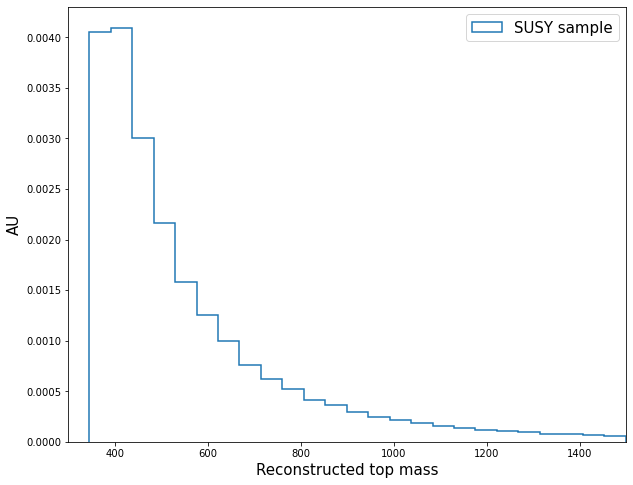

In [116]:
tt_mass = np.array(tt_mass)
fig, ax = plt.subplots(figsize=(10,8))

ax.hist(tt_mass[tt_mass < 1500], bins=25, density=True, histtype='step', label='SUSY sample' , linewidth=1.5)
ax.set_xlim(300, 1500)
plt.xlabel('Reconstructed top mass',  fontsize=15)
plt.ylabel('AU',  fontsize=15)
plt.legend(loc='upper right', fontsize=15)

In [113]:
JES = uproot.open('HL_YR_JEC.root')['TOTAL_BJES_AntiKt4EMTopo_YR2018']

In [124]:
JES.show()

                           0                                            0.036366
                           +---------------------------------------------------+
[-inf, 15)       0         |                                                   |
[15, 15.202)     0.034634  |*************************************************  |
[15.202, 15.609) 0.034089  |************************************************   |
[15.609, 16.028) 0.033557  |***********************************************    |
[16.028, 16.459) 0.033081  |**********************************************     |
[16.459, 16.901) 0.032611  |**********************************************     |
[16.901, 17.354) 0.032024  |*********************************************      |
[17.354, 17.82)  0.031199  |********************************************       |
[17.82, 18.299)  0.030376  |*******************************************        |
[18.299, 18.79)  0.029556  |*****************************************          |
[18.79, 19.294)  0.028756  |

(array([ 11.,  33.,  93., 167., 216., 224., 151.,  76.,  25.,   4.]),
 array([-2.85203828, -2.26230353, -1.67256877, -1.08283402, -0.49309926,
         0.09663549,  0.68637025,  1.276105  ,  1.86583975,  2.45557451,
         3.04530926]),
 <BarContainer object of 10 artists>)

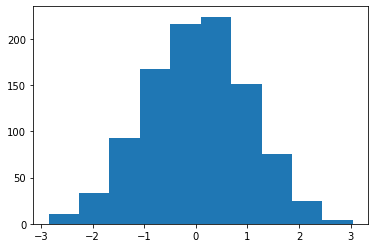

In [24]:
plt.hist(np.random.normal(0, 1, 1000))

In [88]:
pid  = SUSY_ptr['genpart_pid'].array()
mass = SUSY_ptr['genpart_mass'].array()

In [103]:
mass[6][24]

124.87768

In [112]:
tt_mass

[678.4058812496696,
 859.9245358049869,
 662.7769800769388,
 441.10642259843775,
 371.65513145108787,
 721.6691251076845,
 469.75755123953684,
 399.8628497043213,
 392.1636212505573,
 1805.354054467882,
 367.08343878568496,
 397.51842704303004,
 698.1397414456983,
 381.6898359802939,
 600.8334744840212,
 546.1420800403943,
 433.72683270722666,
 410.6404435279127,
 577.7069071024654,
 396.9637147845541,
 584.0445194378603,
 435.0835931435774,
 542.2042657787136,
 680.2822190007714,
 351.19769637799067,
 378.6620533663254,
 369.41423042519176,
 492.8316922468196,
 425.7139243810496,
 422.79034757762327,
 1249.4293760533892,
 365.37091972084346,
 380.7944333590577,
 437.18638264270044,
 397.2258858395401,
 388.85155142145794,
 760.2847382428758,
 463.3304976178377,
 464.7040775667846,
 388.2949557769053,
 689.1284533890515,
 385.0839266675466,
 1398.2802714769873,
 394.2127497732143,
 416.0396707488685,
 513.8329294140193,
 716.5277356885443,
 360.47831186622864,
 449.17013195287393,
 445

In [108]:
no_sol

4352